In [7]:
import json
import numpy as np
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [9]:
with open('./testdump_1.txt') as f:
    json_data = json.load(f)

In [10]:
states = []
actions = []
for sa in json_data:
    states.append(np.array([float(x) for x in sa["state"]["ai_1"]]))
    actions.append(int(sa["ai_1"]))

In [11]:
num_states = len(states[0])
num_actions = max(actions) + 1
print(num_states, num_actions)

39 40


In [12]:
train_states, test_states, train_actions, test_actions = train_test_split(states, actions, test_size=0.15)
tensor_train_states = torch.Tensor(train_states)
tensor_train_actions = torch.Tensor(train_actions)
tensor_test_states = torch.Tensor(test_states)
tensor_test_actions = torch.Tensor(test_actions)

train_dataset = data.TensorDataset(tensor_train_states, tensor_train_actions)
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True) 
test_dataset = data.TensorDataset(tensor_test_states, tensor_test_actions)
test_dataloader = data.DataLoader(test_dataset, batch_size=64) 

In [13]:
bc_agent = nn.Sequential(
    nn.Linear(num_states, 40),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(40, num_actions)
).to(device)
optimizer = torch.optim.Adam(bc_agent.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(weight=torch.Tensor([0.1] + [1] * (num_actions - 1)).to(device))

In [20]:
train_total_losses = []
test_total_losses = []
for epoch in range(200):
    train_total_loss = 0
    train_steps = 0
    for s, a in train_dataloader:
        s = s.float().to(device)
        a = a.long().to(device)
    
        loss = loss_func(bc_agent(s), a)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_steps += 1
        train_total_loss += loss.detach().cpu().numpy()
    train_total_losses.append(train_total_loss / train_steps)
    
    test_total_loss = 0
    test_steps = 0
    for s, a in test_dataloader:
        s = s.float().to(device)
        a = a.long().to(device)
        loss = loss_func(bc_agent(s), a)
        
        test_steps += 1
        test_total_loss += loss.detach().cpu().numpy()
    test_total_losses.append(test_total_loss / test_steps)
    print(f"Epoch {epoch:<5} Train Loss: {train_total_losses[-1]:<5.2f} Test Loss: {test_total_losses[-1]:<5.2f}")

Epoch 0     Train Loss: 1.22  Test Loss: 1.71 
Epoch 1     Train Loss: 1.22  Test Loss: 1.65 
Epoch 2     Train Loss: 1.23  Test Loss: 1.45 
Epoch 3     Train Loss: 1.22  Test Loss: 1.59 
Epoch 4     Train Loss: 1.23  Test Loss: 1.55 
Epoch 5     Train Loss: 1.23  Test Loss: 1.55 
Epoch 6     Train Loss: 1.22  Test Loss: 1.53 
Epoch 7     Train Loss: 1.21  Test Loss: 1.53 
Epoch 8     Train Loss: 1.20  Test Loss: 1.70 
Epoch 9     Train Loss: 1.19  Test Loss: 1.80 
Epoch 10    Train Loss: 1.23  Test Loss: 1.47 
Epoch 11    Train Loss: 1.23  Test Loss: 1.65 
Epoch 12    Train Loss: 1.23  Test Loss: 1.62 
Epoch 13    Train Loss: 1.23  Test Loss: 1.65 
Epoch 14    Train Loss: 1.20  Test Loss: 1.65 
Epoch 15    Train Loss: 1.24  Test Loss: 1.76 
Epoch 16    Train Loss: 1.20  Test Loss: 1.53 
Epoch 17    Train Loss: 1.21  Test Loss: 1.63 
Epoch 18    Train Loss: 1.24  Test Loss: 1.49 
Epoch 19    Train Loss: 1.22  Test Loss: 1.49 
Epoch 20    Train Loss: 1.21  Test Loss: 1.42 
Epoch 21    T

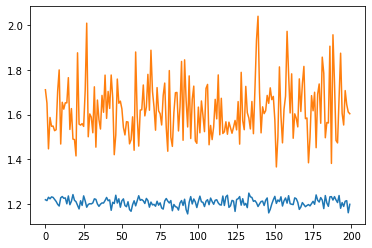

In [21]:
plt.plot(range(len(train_total_losses)), train_total_losses)
plt.plot(range(len(test_total_losses)), test_total_losses)
plt.show()